# Notebook containing the scripts to compare, quantitatively, the mean (corrected) abundances for stellar populations. To do so, we will sample the errors in the measurements and then take the mean and standard error value of every abundance for each sample at a small bin in Fe/H

In [1]:
# import the necessary modules
import numpy as np
from astropy.io import fits
import tqdm
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load the data
path = '/Users/dhortadarrington/Documents/Master/data/DR17_McMillan_astroNN.fits'
tb = fits.open(path)
data = tb[1].data 

In [3]:
fehs = data.field('FE_H')
mgfe = data.field('MG_FE')
alfe = data.field('AL_FE')
kfe = data.field('K_FE')
alfe_err = data.field('AL_FE_ERR')
nafe = data.field('NA_FE')
fehs_err = data.field('FE_H_ERR')
nife = data.field('NI_FE')
cfe = data.field('C_FE')
nfe = data.field('N_FE')
sfe = data.field('S_FE')
cefe = data.field('CE_FE')
tife = data.field('TI_FE')
sife = data.field('SI_FE')
kfe = data.field('K_FE')
ofe = data.field('O_FE')
pfe = data.field('P_FE')
cafe = data.field('CA_FE')
mnfe = data.field('MN_FE')
cife = data.field('CI_FE')
cofe = data.field('CO_FE')
crfe = data.field('CR_FE')
vfe = data.field('V_FE')
cufe = data.field('CU_FE')
tife = data.field('TI_FE')
apo_id = data.field('APOGEE_ID')
logg = data.field('LOGG')
teff = data.field('TEFF')
fehs_err = data.field('FE_H_ERR')
mgfe_err = data.field('MG_FE_ERR')


In [4]:
loadpath =  '/Users/dhortadarrington/Documents/Projects/accreted-systems/sav/paper/'

mask_ges = np.load(loadpath+'mask_ges.npy')
mask_higha_disc_solar = np.load(loadpath+'mask_higha_disc_solar.npy')

mask = np.load(loadpath+'mask_parentsamp.npy')
acc_mask = np.load(loadpath+'mask_accsamp.npy')

print(len(data[mask]))

199030


# Load in the corrected abundances

In [5]:
loadpath =  '/Users/dhortadarrington/Documents/Projects/accreted-systems/sav/paper/abundance_corrections/'
abun_parent = np.load(loadpath+'corrected_4loggsystematic_xfes_parent.npy', allow_pickle=True)
abun_err_parent = np.load(loadpath+'corrected_4loggsystematic_xfes_err_parent.npy', allow_pickle=True)
abun_lowa_aleph = np.load(loadpath+'corrected_4loggsystematic_xfes_lowa_aleph.npy', allow_pickle=True)
parent_ordered_ids = np.load(loadpath+'ordered_ascorrected_abun_apoids_parent.npy', allow_pickle=True)
parent_ordered_fehs = np.load(loadpath+'corrected_4loggsystematic_fehs_parent.npy', allow_pickle=True)
parent_ordered_fehs_err = np.load(loadpath+'corrected_4loggsystematic_fehs_err_parent.npy', allow_pickle=True)


In [6]:
def get_sample_abun(abun_ordered_id_array, apo_id, mask_sample, corr_abun, corr_fehs):
    '''
    abun_ordered_id_array = array containing the ids of the corrected abundances in the same order as logg (this sample is limited to 1 < logg < 2)
    apo_id = parent APOGEE_ID array from the allStar file
    mask_sample = mask of the substructure or sample wanting to get the corrected abundances for
    corr_abun = corrected abundances determined by correcting for systematics with logg. Abundances are as follows = [abundances_list = ['[C/Fe]','[N/Fe]','[O/Fe]','[Na/Fe]','[Mg/Fe]','[Al/Fe]','[Si/Fe]','[S/Fe]','[K/Fe]',\
               '[Ca/Fe]','[Ti/Fe]','[V/Fe]','[Cr/Fe]','[Mn/Fe]','[Fe/H]','[Co/Fe]','[Ni/Fe]','[Ce/Fe]'] 
    corr_fehs = fehs corresponding to the corrected abundances
    '''
    
    corrected_abun_sample = []
    corrected_fehs_sample = []
    
    for indx, i in enumerate(abun_ordered_id_array):
        mask_abun_sample = np.isin(list(i),list(apo_id[mask_sample]))
        corrected_abun_sample.append(corr_abun[indx][mask_abun_sample])
        corrected_fehs_sample.append(corr_fehs[indx][mask_abun_sample])
        
    return corrected_abun_sample, corrected_fehs_sample


In [7]:
corrected_abun_ges,corrected_fehs_ges = get_sample_abun(parent_ordered_ids, apo_id, mask_ges,abun_parent, parent_ordered_fehs)
corrected_abun_higha_solar,corrected_fehs_higha_solar = get_sample_abun(parent_ordered_ids, apo_id, mask_higha_disc_solar,abun_parent, parent_ordered_fehs)


In [8]:
corrected_abun_err_ges,corrected_fehs_err_ges = get_sample_abun(parent_ordered_ids, apo_id, mask_ges,abun_err_parent, parent_ordered_fehs_err)
corrected_abun_err_higha_solar,corrected_fehs_err_higha_solar = get_sample_abun(parent_ordered_ids, apo_id, mask_higha_disc_solar,abun_err_parent, parent_ordered_fehs_err)


Corrected abundances are saved as:

['[C/Fe]'(0),'[N/Fe]'(1),'[O/Fe]'(2),'[Na/Fe]'(3),'[Mg/Fe]'(4),'[Al/Fe]'(5),'[Si/Fe]'(6),'[S/Fe]'(7),'[K/Fe]'(8),\
'[Ca/Fe]'(9),'[Ti/Fe]'(10),'[V/Fe]'(11),'[Cr/Fe]'(12),'[Mn/Fe]'(13),'[Fe/H]'(14),'[Co/Fe]'(15),'[Ni/Fe]'(16),'[Ce/Fe]'(17)] 


In [9]:
from astropy.stats import bootstrap

def samples(abun, abun_err, xs, xs_err,n,fehs_val,delta_feh):
    
    samples_abun = np.zeros((len(abun),n))
    samples_xs = np.zeros((len(abun),n))
    samples_median = np.zeros((n))
    n_samples = len(abun)
    
    # create the bootstrap samples  
    # in order to sample the distribution using bootstrap with resampling and to get the correct
    # information for every star picked, we need to sample an id array, and use that to pick out the sampled stars
    # otherwise you get incorrect fehs for every abundance
    random_ids = np.arange(len(abun))
    samples_indices = bootstrap(random_ids, n).astype(int)
            
    for indx3, k in enumerate(samples_indices):
        # find the stars with the correct id
        mask_feh = (xs[k] < delta_feh+fehs_val)&(xs[k] > fehs_val-delta_feh)
        samples_median[indx3] = np.nanmedian(abun[k][mask_feh])
    return samples_median

def find_mean_scatter_norm(abundances, abundances_err,xs,xs_err,fehs_val = -1,delta_feh=0.05,n=1000):


    abundances_list = ['[O/Fe]','[Mg/Fe]','[Si/Fe]','[S/Fe]','[Ca/Fe]','[Ti/Fe]','[C/Fe]',\
                       '[N/Fe]','[Al/Fe]','[K/Fe]','[Mn/Fe]','[Ni/Fe]','[Ce/Fe]']
    
    xfe_mean = np.zeros((len(abundances)))
    xfe_scatter = np.zeros((len(abundances)))
    xfe_meanerr = np.zeros((len(abundances)))
    samples_median = np.zeros((len(abundances),n))
    for indx, i in tqdm.tqdm_notebook(enumerate(abundances)):
        # make sure you are comparing stars with same logg (already did this when correcting systematics)
        # abundances compared here are between 1 < logg < 2        
        abun = i # abundances in the sample
        xs2 = xs[indx] # feh values in the sample
        abun_err = abundances_err[indx] # errors in the abundances in the sample
        xs2_err = xs_err[indx] # errors in the feh values in the sample

        # draw N samples for every x and y point, fit a line to every N distribution of the x, y plane, and get
        # the mean and sigma values of your slope and intercept
        samples_median_raw = samples(abun, abun_err, xs2, xs2_err,n,fehs_val,delta_feh)
        samples_median[indx] = samples_median_raw
        # determine the mean value of the abundances calculated by taking the mean value of the 1,000 medians
        # also calculate the sigma by taking the standard deviation of the 1,000 medians
        xfe_mean[indx] = np.nanmean(samples_median_raw)
        xfe_scatter[indx] = np.nanstd(samples_median_raw)
        xfe_meanerr[indx] = np.nanstd(samples_median_raw)/np.sqrt(len(samples_median_raw))
    return xfe_mean,xfe_scatter,xfe_meanerr


In [10]:
# Corrected abundances are saved as:
# ['[C/Fe]'(0),'[N/Fe]'(1),'[O/Fe]'(2),'[Na/Fe]'(3),'[Mg/Fe]'(4),'[Al/Fe]'(5),'[Si/Fe]'(6),'[S/Fe]'(7),'[K/Fe]'(8),\
# '[Ca/Fe]'(9),'[Ti/Fe]'(10),'[V/Fe]'(11),'[Cr/Fe]'(12),'[Mn/Fe]'(13),'[Fe/H]'(14),'[Co/Fe]'(15),'[Ni/Fe]'(16),'[Ce/Fe](17)'] 

abun_ges = np.array((corrected_abun_ges[2],corrected_abun_ges[4],corrected_abun_ges[6],corrected_abun_ges[7],\
                    corrected_abun_ges[9],corrected_abun_ges[10],corrected_abun_ges[0],corrected_abun_ges[1],\
                    corrected_abun_ges[5],corrected_abun_ges[8],corrected_abun_ges[13],corrected_abun_ges[16],\
                    corrected_abun_ges[17]))
abun_ges_err = np.array((corrected_abun_err_ges[2],corrected_abun_err_ges[4],corrected_abun_err_ges[6],corrected_abun_err_ges[7],\
                    corrected_abun_err_ges[9],corrected_abun_err_ges[10],corrected_abun_err_ges[0],corrected_abun_err_ges[1],\
                    corrected_abun_err_ges[5],corrected_abun_err_ges[8],corrected_abun_err_ges[13],corrected_abun_err_ges[16],\
                    corrected_abun_err_ges[17]))
fehs_ges = np.array((corrected_fehs_ges[2],corrected_fehs_ges[4],corrected_fehs_ges[6],corrected_fehs_ges[7],\
                    corrected_fehs_ges[9],corrected_fehs_ges[10],corrected_fehs_ges[0],corrected_fehs_ges[1],\
                    corrected_fehs_ges[5],corrected_fehs_ges[8],corrected_fehs_ges[13],corrected_fehs_ges[16],\
                    corrected_fehs_ges[17]))
fehs_err_ges = np.array((corrected_fehs_err_ges[2],corrected_fehs_err_ges[4],corrected_fehs_err_ges[6],corrected_fehs_err_ges[7],\
                    corrected_fehs_err_ges[9],corrected_fehs_err_ges[10],corrected_fehs_err_ges[0],corrected_fehs_err_ges[1],\
                    corrected_fehs_err_ges[5],corrected_fehs_err_ges[8],corrected_fehs_err_ges[13],corrected_fehs_err_ges[16],\
                    corrected_fehs_err_ges[17]))

xfe_mean_ges ,xfe_scatter_ges ,xfe_meanerr_ges = find_mean_scatter_norm(abun_ges,abun_ges_err,fehs_ges,fehs_err_ges, fehs_val = -0.9 )


0it [00:00, ?it/s]

In [11]:
abun_higha_solar = np.array((corrected_abun_higha_solar[2],corrected_abun_higha_solar[4],corrected_abun_higha_solar[6],corrected_abun_higha_solar[7],\
                    corrected_abun_higha_solar[9],corrected_abun_higha_solar[10],corrected_abun_higha_solar[0],corrected_abun_higha_solar[1],\
                    corrected_abun_higha_solar[5],corrected_abun_higha_solar[8],corrected_abun_higha_solar[13],corrected_abun_higha_solar[16],\
                    corrected_abun_higha_solar[17]))
abun_higha_solar_err = np.array((corrected_abun_err_higha_solar[2],corrected_abun_err_higha_solar[4],corrected_abun_err_higha_solar[6],corrected_abun_err_higha_solar[7],\
                    corrected_abun_err_higha_solar[9],corrected_abun_err_higha_solar[10],corrected_abun_err_higha_solar[0],corrected_abun_err_higha_solar[1],\
                    corrected_abun_err_higha_solar[5],corrected_abun_err_higha_solar[8],corrected_abun_err_higha_solar[13],corrected_abun_err_higha_solar[16],\
                    corrected_abun_err_higha_solar[17]))
fehs_higha_solar = np.array((corrected_fehs_higha_solar[2],corrected_fehs_higha_solar[4],corrected_fehs_higha_solar[6],corrected_fehs_higha_solar[7],\
                    corrected_fehs_higha_solar[9],corrected_fehs_higha_solar[10],corrected_fehs_higha_solar[0],corrected_fehs_higha_solar[1],\
                    corrected_fehs_higha_solar[5],corrected_fehs_higha_solar[8],corrected_fehs_higha_solar[13],corrected_fehs_higha_solar[16],\
                    corrected_fehs_higha_solar[17]))
fehs_err_higha_solar = np.array((corrected_fehs_err_higha_solar[2],corrected_fehs_err_higha_solar[4],corrected_fehs_err_higha_solar[6],corrected_fehs_err_higha_solar[7],\
                    corrected_fehs_err_higha_solar[9],corrected_fehs_err_higha_solar[10],corrected_fehs_err_higha_solar[0],corrected_fehs_err_higha_solar[1],\
                    corrected_fehs_err_higha_solar[5],corrected_fehs_err_higha_solar[8],corrected_fehs_err_higha_solar[13],corrected_fehs_err_higha_solar[16],\
                    corrected_fehs_err_higha_solar[17]))

xfe_mean_higha_solar ,xfe_scatter_higha_solar ,xfe_meanerr_higha_solar = find_mean_scatter_norm(abun_higha_solar,abun_higha_solar_err,fehs_higha_solar,fehs_err_higha_solar, fehs_val = -0.9 )


0it [00:00, ?it/s]

In [14]:
from scipy import stats

abundances_list = ['[O/Fe]','[Mg/Fe]','[Si/Fe]','[S/Fe]','[Ca/Fe]','[Ti/Fe]','[C/Fe]','[N/Fe]','[Al/Fe]','[K/Fe]',\
                   '[Mn/Fe]','[Ni/Fe]','[Ce/Fe]']
                   

In [13]:
def get_chi2(observed_mean,predicted_mean, observed_error, predicted_error):
    from scipy import stats
    
    result = np.zeros((len(observed_mean)))
    for indx, i in enumerate(observed_mean):
        result[indx] = ((i-predicted_mean[indx])**2)/(observed_error[indx]**2+predicted_error[indx]**2)
    chi2 = np.sum((result))
    return chi2

def get_diff(observed_mean,predicted_mean):
    result = np.zeros((len(observed_mean)))
    for indx, i in enumerate(observed_mean):
        result[indx] = ((i-predicted_mean[indx])**2)
    diff = np.sum((result))
    return diff

Text(11.4, -0.5, '$s$-process')

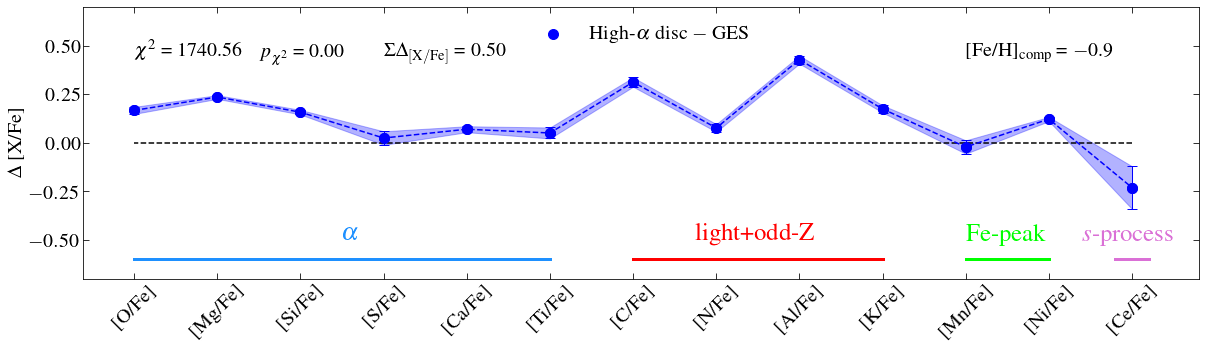

In [15]:

plt.figure(figsize=(20,5))
chi2 = get_chi2(xfe_mean_ges, xfe_mean_higha_solar, xfe_scatter_ges, xfe_scatter_higha_solar)
diff = get_diff(xfe_mean_ges, xfe_mean_higha_solar)
pvalue = 1 - stats.chi2.cdf(chi2, 12)

err_highadisc_ges = np.sqrt(xfe_scatter_ges**2+xfe_scatter_higha_solar**2)
diff_highadisc_ges = xfe_mean_higha_solar-xfe_mean_ges

plt.fill_between(abundances_list, diff_highadisc_ges+err_highadisc_ges,diff_highadisc_ges-err_highadisc_ges,alpha=0.3,color='b' )
plt.errorbar(abundances_list,diff_highadisc_ges,yerr= err_highadisc_ges,fmt='o--',markersize=10, color='b',ecolor='b',\
             elinewidth=1, capsize=5)
plt.scatter(abundances_list,diff_highadisc_ges,c='b',s=100,label=r'High-$\alpha$ disc $-$ GES')
plt.hlines(0,12,0,ls='dashed',color='k')
plt.legend(loc='upper center',frameon=False,ncol=2,fontsize=20)
plt.tick_params(labelsize=20,direction='in',top=True,right=True,length=6)
plt.ylim(-0.7,0.7)
plt.xticks(rotation=45)
plt.ylabel(r'$\Delta$ [X/Fe]', fontsize=20)
plt.text(0,0.45,r'$\chi^{2}$ = '+str("{:.2f}".format(chi2)), fontsize=20)
plt.text(1.5,0.45,r'$p_{\chi^{2}}$ = '+str("{:.2f}".format(pvalue)), fontsize=20)
plt.text(3,0.45,r'$\Sigma$$\Delta_{\mathrm{[X/Fe]}}$ = '+str("{:.2f}".format(diff)), fontsize=20)
plt.text(10,0.45,r'[Fe/H]$_{\mathrm{comp}}$ = $-$0.9', fontsize=20)

plt.plot(abundances_list[:6], np.array([-0.6,-0.6,-0.6,-0.6,-0.6,-0.6]), c='dodgerblue',lw=3)
plt.plot(abundances_list[6:10], np.array([-0.6,-0.6,-0.6,-0.6]), c='r',lw=3)
plt.plot(abundances_list[10:12], np.array([-0.6,-0.6]), c='lime',lw=3)
plt.plot(np.array([11.8,12.2]), np.array([-0.6,-0.6]), c='orchid',lw=3)
plt.text(2.5,-0.5,r'$\alpha$',color='dodgerblue',fontsize=25)
plt.text(6.75,-0.5,r'light+odd-Z',color='r',fontsize=25)
plt.text(10.,-0.5,r'Fe-peak',color='lime',fontsize=25)
plt.text(11.4,-0.5,r'$s$-process',color='orchid',fontsize=25)